# Investigating the functions


In [1]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern

f1_inp = np.load("./../function_1/initial_inputs.npy")
f1_out = np.load("./../function_1/initial_outputs.npy")


In [2]:
f1_inp, f1_out

(array([[0.31940389, 0.76295937],
        [0.57432921, 0.8798981 ],
        [0.73102363, 0.73299988],
        [0.84035342, 0.26473161],
        [0.65011406, 0.68152635],
        [0.41043714, 0.1475543 ],
        [0.31269116, 0.07872278],
        [0.68341817, 0.86105746],
        [0.08250725, 0.40348751],
        [0.88388983, 0.58225397]]),
 array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
        -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
         6.22985647e-048]))

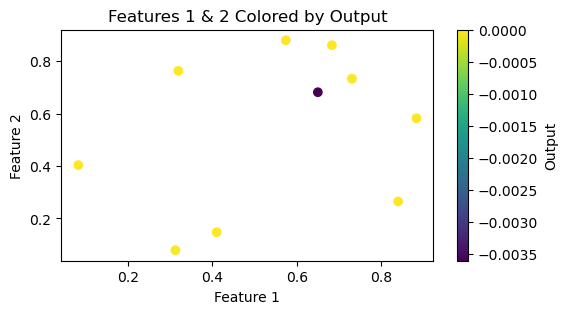

In [55]:
plt.figure(figsize=(6, 3))

# Plot: Features 1 & 2 Colored by Output
scatter = plt.scatter(f1_inp[:, 0], f1_inp[:, 1], c=f1_out, cmap='viridis')
plt.colorbar(scatter, label="Output")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Features 1 & 2 Colored by Output")

plt.show()


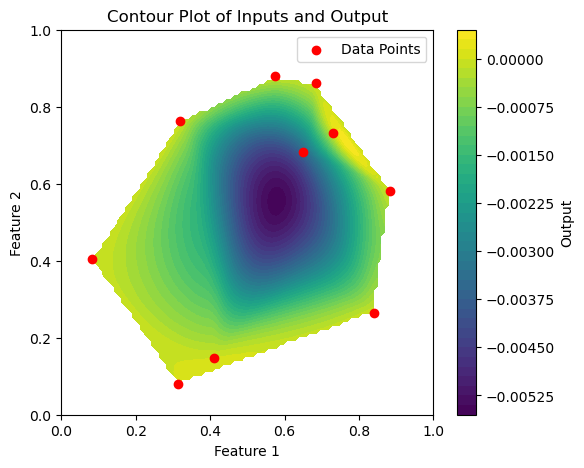

In [40]:
from scipy.interpolate import griddata

# Create grid
x = f1_inp[:, 0]
y = f1_inp[:, 1]
z = f1_out
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

plt.figure(figsize=(6, 5))
plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis')
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', label="Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output")
plt.legend()
plt.show()


In [50]:
max_index_out = np.argmax(f1_out)
max_index_out
max_output = f1_out[max_index_inpu]

print(f"Best score found on index {max_index_out}")
max_param = f1_inp[max_index_inpu]
max_param,max_output




Best score found on index 2


(array([0.73102363, 0.73299988]), 7.710875114502849e-16)

In [103]:
# I need a R library to test diffrent optimisation for kernel 
#   pip install GPy


In [104]:
from sklearn.gaussian_process.kernels import Matern

# Load the data
f1_inp = np.load("./function_1/initial_inputs.npy")  # Input data (2D coordinates)
f1_out = np.load("./function_1/initial_outputs.npy")  # Output data (radiation values)

f1_out = f1_out.reshape(-1, 1)  # Ensure outputs are 2D for GP fittin




# Define the updated kernel with adjusted bounds
# I am researching the different choices of Kernel and found a example of best way how to adjust 
# the parameters of kernel, I will use MLE to do that, and see the result I get back 
# source: https://d-nb.info/1143432258/34




from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel

# Declare kernel parameters
length_scale = 0.1  # Typical starting value for length scale
length_scale_bounds = (1e-2, 100)  # Common range for length scale in GP applications

length_scale = 0.1
length_scale_bounds = (1e-4, 10)

noise_level = 0.1
noise_level_bounds = (1e-8, 1e-4)

# Define the kernel using declared variables
kernel = (
    C(signal_variance, signal_variance_bounds)  # Signal variance with bounds
    * Matern(length_scale=length_scale, length_scale_bounds=length_scale_bounds, nu=1.5)  # Matérn kernel
    + WhiteKernel(noise_level=noise_level, noise_level_bounds=noise_level_bounds)  # Noise kernel
)

# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
# gp.fit(f1_inp, f1_out)
# print(gp.kernel_)

Optimized Kernel Parameters: 
0.0011**2 * Matern(length_scale=0.000127, nu=1.5) + WhiteKernel(noise_level=9.37e-08)

- I have tested difrent parameters of kernel and raise the bounds as per the error instrusctions to raise the bounds as we might miss some good values. 

In [86]:
# import GPy #### I WILL KEEP THIS ON HOLD 
# # Define the GPy kernel with the same bounds
# kernel = GPy.kern.Matern32(
#     input_dim=2, 
#     variance=1.0, 
#     lengthscale=0.1
# )
# kernel.variance.constrain_bounded(1e-6, 1)  # Match bounds with scikit-learn
# kernel.lengthscale.constrain_bounded(1e-4, 10)  # Match bounds with scikit-learn
# # Create and fit the Gaussian Process model
# model = GPy.models.GPRegression(f1_inp, f1_out, kernel)
# model.optimize(messages=True)  # Optimize kernel parameters via MLE
# # Display the optimized kernel parameters
# print("Optimized Kernel Parameters (GPy):")
# print(model)

# Input Transformation 
First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [120]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
f1_inp_normalized, f1_inp

(array([[0.29560992, 0.85404102],
        [0.61371681, 1.        ],
        [0.80924692, 0.81664659],
        [0.94567337, 0.23216995],
        [0.70828444, 0.75239907],
        [0.40920516, 0.08591318],
        [0.28723348, 0.        ],
        [0.74984275, 0.97648375],
        [0.        , 0.40536037],
        [1.        , 0.62849064]]),
 array([[0.31940389, 0.76295937],
        [0.57432921, 0.8798981 ],
        [0.73102363, 0.73299988],
        [0.84035342, 0.26473161],
        [0.65011406, 0.68152635],
        [0.41043714, 0.1475543 ],
        [0.31269116, 0.07872278],
        [0.68341817, 0.86105746],
        [0.08250725, 0.40348751],
        [0.88388983, 0.58225397]]))

In [128]:
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel



In [133]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import cross_val_score

# Define the Kumaraswamy warping function
def kumaraswamy_warp(x, a, b):
    return 1 - (1 - x**a)**b

# Define a function to evaluate model performance
def evaluate_model_score(X, y):
    # Normalize the input
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    
    # Adjusted kernel bounds many times
    # I have UPDATED KERNEL with REGULARISATION, by increasing the lowerbound or the inital noise, to prevent overfiting
    kernel = (
        C(1e-2, (1e-8, 1))  # Signal variance bounds
        * Matern(length_scale=0.1, length_scale_bounds=(1e-4, 2000), nu=1.5)  # Length scale
        + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-5, 1e-3))  # Regularized noise level
    )

    # Create a Gaussian Process Regressor
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

    # Perform cross-validation and return the mean score
    scores = cross_val_score(gp, X_normalized, y, cv=3, scoring="neg_mean_squared_error")
    return scores.mean()

# Define parameter ranges for Kumaraswamy warping
a_values = np.linspace(0.1, 5, 10)
b_values = np.linspace(0.1, 5, 10)

# Placeholder for the best parameters
best_a, best_b, best_score = None, None, -np.inf

# Assume `f1_inp_normalized` and `f1_out` are already defined
# If not, normalize the inputs and prepare them first:
# scaler = MinMaxScaler()
# f1_inp_normalized = scaler.fit_transform(f1_inp)

for a in a_values:
    for b in b_values:
        # Apply Kumaraswamy warping
        warped_input = kumaraswamy_warp(f1_inp_normalized, a, b)

        # Evaluate the model with warped inputs
        score = evaluate_model_score(warped_input, f1_out)

        # Keep track of the best parameters
        if score > best_score:
            best_a, best_b, best_score = a, b, score

# Output the best parameters
print(f"Best Parameters: a={best_a}, b={best_b}, Score={best_score}")


 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found f

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found f

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found f

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found f

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 2000.0. Increasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found f

Best Parameters: a=3.911111111111112, b=5.0, Score=-1.4448627567918906e-06


 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-08. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found 

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.

Best Parameters for the CDF : a=5.0, b=0.6444444444444445, Score=-1.652678616814196e-06


Second Guess - Best Parameters: a=0.1, b=0.1, Score=-1.6524935877874082e-06

Third Test:  Parameters: a=0.1, b=0.1, Score=-1.641027418617411e-06

Fourth Test: Best Parameters: a=0.1, b=0.6444444444444445, Score=-1.444854199452721e-06

Fifth Test: Best Parameters: a=3.911111111111112, b=5.0, Score=-1.4448627567918906e-06

In [143]:
# Kumaraswamy CDF function
def kumaraswamy_warp(x, a, b):
    return 1 - (1 - x**a)**b

# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.1, b=0.6444444444444445)
f1_inp, f1_inp_warped

(array([[0.31940389, 0.76295937],
        [0.57432921, 0.8798981 ],
        [0.73102363, 0.73299988],
        [0.84035342, 0.26473161],
        [0.65011406, 0.68152635],
        [0.41043714, 0.1475543 ],
        [0.31269116, 0.07872278],
        [0.68341817, 0.86105746],
        [0.08250725, 0.40348751],
        [0.88388983, 0.58225397]]),
 array([[0.75223886, 0.93136706],
        [0.85936863, 1.        ],
        [0.91720598, 0.919495  ],
        [0.96473527, 0.72372596],
        [0.88706737, 0.90005552],
        [0.79505383, 0.62570768],
        [0.74871652, 0.        ],
        [0.89929761, 0.97963036],
        [0.        , 0.79372288],
        [1.        , 0.86371986]]))

In [144]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
# Apply Yeo-Johnson transformation


In [154]:
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(f1_inp_warped, f1_out)

from scipy.stats import norm

def expected_improvement(X, gp, y_best, xi=0.01):
    """
    Calculate the Expected Improvement (EI) acquisition function.
    Args:
        X (ndarray): Input points for evaluation (2D array).
        gp (GaussianProcessRegressor): Fitted GP model.
        y_best (float): Best observed value.
        xi (float): Exploration-exploitation trade-off parameter.
    Returns:
        EI (ndarray): Expected improvement at each input point.
    """
    mu, sigma = gp.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)  # Ensure sigma is 2D for consistency

    # Compute EI
    with np.errstate(divide='warn'):
        Z = (mu - y_best - xi) / sigma
        ei = (mu - y_best - xi) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma.flatten() == 0.0] = 0.0  # Handle zero variance safely
    return ei.ravel()  # Return EI as a flattened array



from scipy.stats import norm

# Define bounds for the search
bounds = [(0, 1) for _ in range(f1_inp_warped.shape[1])]

# Best observed value
y_best = np.max(f1_out)

# Optimize the acquisition function
def optimize_acquisition(acquisition_func, gp, y_best, bounds):
    def min_obj(X):
        return -acquisition_func(X.reshape(1, -1), gp, y_best)

    res = minimize(
        fun=min_obj,
        x0=np.random.uniform(bounds[0][0], bounds[0][1], size=(len(bounds),)),
        bounds=bounds,
        method="L-BFGS-B"
    )
    return res.x

# Find the next best point
next_point = optimize_acquisition(expected_improvement, gp, y_best, bounds)
print("Next Best Point:", next_point)



Next Best Point: [0.65272929 0.11789805]


 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.


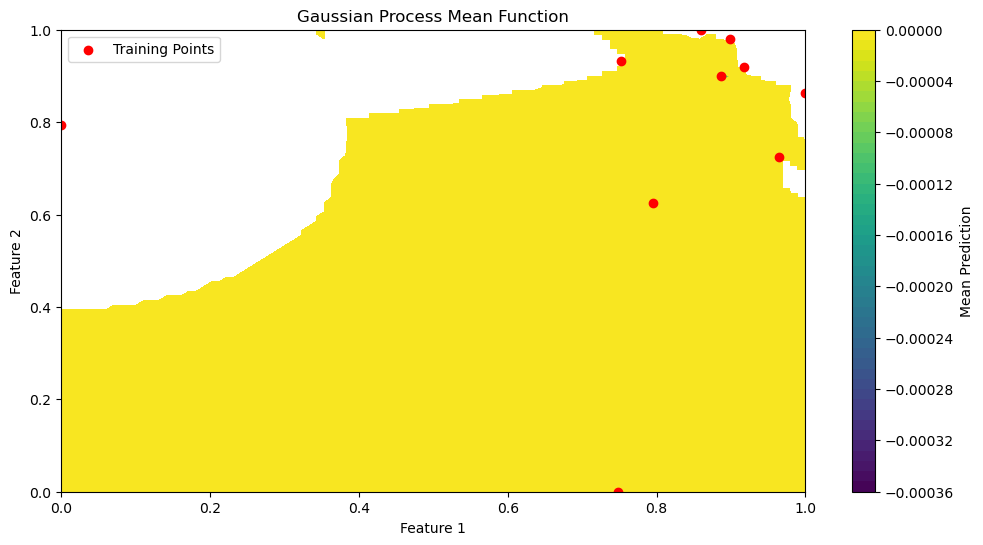

ValueError: cannot reshape array of size 100000000 into shape (100,100)

In [155]:
# Generate a 2D grid for test points
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
X_test = np.c_[X1.ravel(), X2.ravel()]  # Flatten into a 2D array

# Predict mean and standard deviation
mu, sigma = gp.predict(X_test, return_std=True)
mu = mu.reshape(X1.shape)  # Reshape for plotting
sigma = sigma.reshape(X1.shape)

# Plot mean function
plt.figure(figsize=(12, 6))
plt.contourf(X1, X2, mu, levels=50, cmap="viridis")
plt.colorbar(label="Mean Prediction")
plt.scatter(f1_inp_warped[:, 0], f1_inp_warped[:, 1], color="red", label="Training Points")
plt.title("Gaussian Process Mean Function")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Plot acquisition function
ei_values = expected_improvement(X_test, gp, y_best)
ei_values = ei_values.reshape(X1.shape)  # Reshape for plotting
plt.figure(figsize=(12, 6))
plt.contourf(X1, X2, ei_values, levels=50, cmap="plasma")
plt.colorbar(label="Acquisition Function (EI)")
plt.scatter(f1_inp_warped[:, 0], f1_inp_warped[:, 1], color="red", label="Training Points")
plt.title("Acquisition Function (Expected Improvement)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
